In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

In [56]:
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [77]:
# Function to calculate MASE (Mean Absolute Scaled Error)
def mase(y_true, y_pred, y_train):
    naive_forecast = np.roll(y_train, shift=1)[1:]
    mae_naive = np.mean(np.abs(y_train[1:] - naive_forecast))
    return np.mean(np.abs(y_true - y_pred)) / mae_naive

In [58]:
# Load the dataset
data = pd.read_csv("AirtrafficA4.csv")

month_mapping = {
    'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4,
    'MAY': 5, 'JUNE': 6, 'JULY': 7, 'AUG': 8,
    'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12
}

data['MONTH'] = data['MONTH'].str.strip().map(month_mapping)

# Create a proper datetime column using the first day of each month
data['DATE'] = pd.to_datetime(data[['YEAR', 'MONTH']].assign(DAY=1))
last_month_actual = data['DATE'].max()
# Convert dates to string in 'MM-YYYY' format for x-axis labels
data['DATE_STR'] = data['DATE'].dt.strftime('%m-%Y')

data.set_index('DATE', inplace=True)
# Ensure the DataFrame is sorted by the DATE index
data.sort_index(inplace=True)

# Set to False if you want to include the covid data in the forecast
predict_without_covid = True

if predict_without_covid:
    # Storing last month to use it for reindexing while saving the forecasted data 
    last_month = data.index[-1]
    # Now neglecting the covid data as it performs like an outlier to out model 
    outlier_date = pd.date_range(start = '2020-03-01' , end = '2022-02-01',freq='MS')
    # Now remove this from the data 
    data = data.loc[~data.index.isin(outlier_date)]
    resetted_index = pd.date_range(start='2013-01-01',periods = len(data), freq='MS')
    data.index = resetted_index
    data.index.name = 'DATE'


# Removing nan data
data = data.ffill()

# Filter relevant columns (assume 'Passengers Carried' is the target)
target_column = 'PASSENGERS CARRIED'
feature_columns = ['TOTAL DEPARTURES', 'HOURS FLOWN', 'KILOMETRE FLOWN', 'AVAILABLE SEAT KILOMETRE (IN THOUSAND)',' FREIGHT CARRIED (IN TONNE)','MAIL CARRIED (IN TONNE)']

for col in feature_columns:
    data[col] = data[col].replace(',', '', regex=True).astype(float)

if data['PASSENGERS CARRIED'].dtype == 'object':
        data['PASSENGERS CARRIED'] = pd.to_numeric(data['PASSENGERS CARRIED'].str.replace(',', ''), errors='coerce')
else : 
    data['PASSENGERS CARRIED'] = pd.to_numeric(data['PASSENGERS CARRIED'], errors='coerce')

In [59]:
test_len = int(0.2*(len(data)))

train_data = data[:-test_len]
test_data = data[-test_len:]

In [66]:
train_data = train_data.reset_index().rename(columns={'DATE': 'ds', target_column: 'y'})

model = Prophet()
for col in feature_columns:
    model.add_regressor(col)
model.fit(train_data)

test_data = test_data.reset_index().rename(columns={'DATE': 'ds', target_column: 'y'})
forecast = model.predict(test_data)

18:18:54 - cmdstanpy - INFO - Chain [1] start processing
18:18:55 - cmdstanpy - INFO - Chain [1] done processing


    index         ds AIRLINE  YEAR  MONTH  TOTAL DEPARTURES  HOURS FLOWN  \
0       0 2020-01-01    A007  2020      1           42555.0      75909.0   
1       1 2020-02-01    A007  2020      2           41162.0      73172.0   
2       2 2020-03-01    A007  2022      3           41982.0      71009.0   
3       3 2020-04-01    A007  2022      4           43927.0      75080.0   
4       4 2020-05-01    A007  2022      5           45450.0      78684.0   
5       5 2020-06-01    A007  2022      6           44205.0      76159.0   
6       6 2020-07-01    A007  2022      7           43029.0      73669.0   
7       7 2020-08-01    A007  2022      8           43171.0      73509.0   
8       8 2020-09-01    A007  2022      9           42458.0      62801.0   
9       9 2020-10-01    A007  2022     10           45536.0      77994.0   
10     10 2020-11-01    A007  2022     11           43379.0      74633.0   
11     11 2020-12-01    A007  2022     12           46194.0      80043.0   
12     12 20

In [61]:
def forecast_plotting_cross_validation(train_data,test_data,forecast) :
    plt.figure(figsize=(10, 5))
    plt.plot(train_data.index, train_data['y'], label='Train', color='blue')
    plt.plot(len(train_data) + test_data.index, test_data['y'], label='Test', color='green')
    plt.plot(len(train_data) + test_data.index, forecast['yhat'], label='Forecast', color='red')
    plt.legend()
    plt.title('prophet Forecast vs Actual')
    plt.show()  
    return 

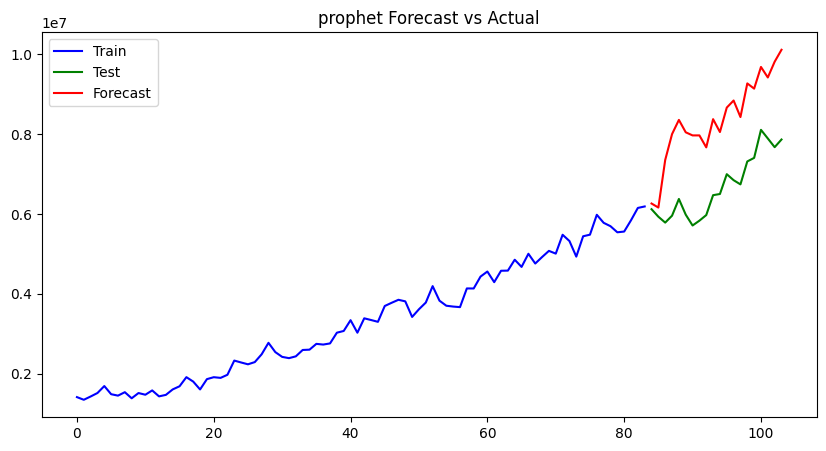

MAPE = 20.008979663959746
MASE = 10.164315277868141


In [78]:
# Now only the relevant columns are kept
forecast = forecast[['yhat','TOTAL DEPARTURES', 'HOURS FLOWN', 'KILOMETRE FLOWN', 'AVAILABLE SEAT KILOMETRE (IN THOUSAND)',' FREIGHT CARRIED (IN TONNE)','MAIL CARRIED (IN TONNE)']]
# forecast = forecast[['yhat']]

forecast.index = test_data['ds']
forecast_plotting_cross_validation(train_data,test_data,forecast)
print(f'MAPE = {MAPE(forecast['yhat'].values,test_data['y'].to_numpy())}')
print(f'MASE = {mase(forecast['yhat'].values,test_data['y'].to_numpy(),train_data['y'].to_numpy())}')

In [82]:
# Now train on the whole data and forecast for the next 12 months
data = data.reset_index().rename(columns={'DATE': 'ds', target_column: 'y'})

model = Prophet()
for col in feature_columns:
    model.add_regressor(col)
model.fit(data)

future = model.make_future_dataframe(periods=12, freq='MS',include_history=False)

window_size = 6  
for regressor in feature_columns:
    if regressor in data.columns:
        future[regressor] = data[regressor].rolling(window=window_size).mean().iloc[-1]

forecast = model.predict(future)
forecast = forecast[['yhat','TOTAL DEPARTURES', 'HOURS FLOWN', 'KILOMETRE FLOWN', 'AVAILABLE SEAT KILOMETRE (IN THOUSAND)',' FREIGHT CARRIED (IN TONNE)','MAIL CARRIED (IN TONNE)']]

18:26:57 - cmdstanpy - INFO - Chain [1] start processing
18:26:57 - cmdstanpy - INFO - Chain [1] done processing


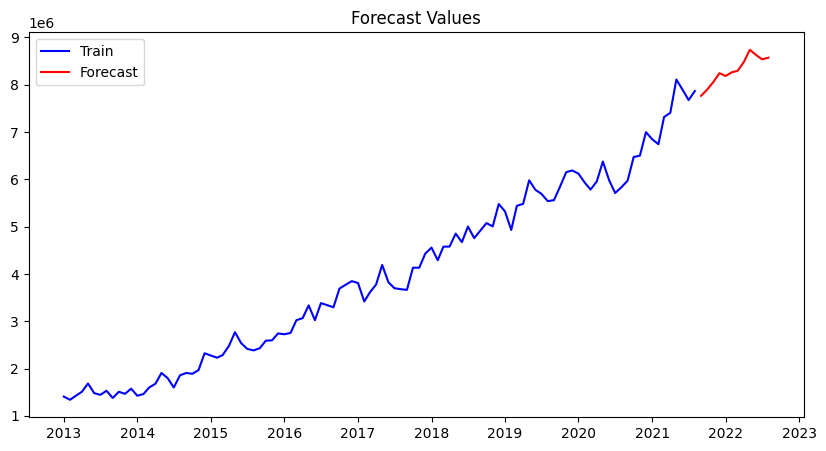

2023-09-01    7.765932e+06
2023-10-01    7.897464e+06
2023-11-01    8.058027e+06
2023-12-01    8.243343e+06
2024-01-01    8.184697e+06
2024-02-01    8.263576e+06
2024-03-01    8.292210e+06
2024-04-01    8.478708e+06
2024-05-01    8.738304e+06
2024-06-01    8.626903e+06
2024-07-01    8.536522e+06
2024-08-01    8.570854e+06
Freq: MS, Name: yhat, dtype: float64


In [84]:
# Now plot the forecasted data
# Last date after on which we forcast 

last_date = data['ds'].iloc[-1]
months_to_predict = 12

forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=months_to_predict, freq='MS')

forecast.index = forecast_index

# Plotting for visualization of the forecasted data 
plt.figure(figsize=(10, 5))
plt.plot(data['ds'], data['y'], label='Train', color='blue')
plt.plot(forecast.index, forecast['yhat'], label='Forecast', color='red')
plt.legend()
plt.title('Forecast Values')
plt.show()

# If covid data was neglected, reindex the forecasted data to include the last month
if predict_without_covid:
    # Update the reindexing line
    new_index = pd.date_range(start=last_month_actual + pd.DateOffset(months=1), periods=months_to_predict, freq='MS')
    forecast.index = new_index

print(forecast['yhat'])
